1. Data Preparation.ipynb

Purpose: Load, clean, and preprocess the dataset.
Contents:
Import and inspect data.
Visualize samples of images and classes.
Preprocess images (resize, normalize, etc.).
Split data into training, validation, and test sets.
Save processed data to disk (if needed) to avoid re-running preprocessing steps.

In [35]:
import tensorflow as tf

#path to our cropped images
dataset_path = 'archive/crop/'


dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size=(128, 128),  # Adjust the image size to 128 x 128 for faster processing
    batch_size=32,          # How many samples we want to load / batch
    shuffle=True            #
)

# Optionally, inspect the class names
class_names = dataset.class_names
print("Class Names:", class_names)

Found 4952 files belonging to 15 classes.
Class Names: ['A10', 'A400M', 'AG600', 'AH64', 'AV8B', 'An124', 'An22', 'An225', 'An72', 'B1', 'B2', 'B21', 'B52', 'Be200', 'C130']


In [36]:
def normalize_images(images, labels):
    images = images / 255.0  # Normalize pixel values to [0, 1]
    return images, labels

# Apply normalization to the dataset
normalized_dataset = dataset.map(normalize_images)

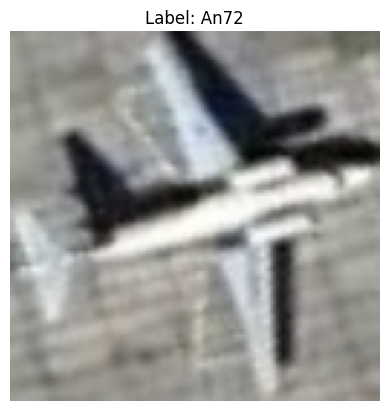

In [37]:
import matplotlib.pyplot as plt

# Example: Iterate through the dataset
for images, labels in dataset.take(1):  # Take one batch
    
    # Select the first image and its corresponding label
    image = images[6].numpy()  # Convert tensor to numpy array
    label = labels[6].numpy()  # Convert tensor to numpy array
    
    #Display Label
    class_name = class_names[label] if len(class_names) > label else 'Unknown'

    #Plot the image
    plt.imshow(image.astype("uint8"))  # Convert float to uint8 for correct display
    plt.title(f"Label: {class_name}")
    plt.axis('off')  # Turn off axis labels
    plt.show()

In [38]:
# Set the split sizes
train_size = 0.7  # 70% for training
val_size = 0.2    # 20% for validation
test_size = 0.1   # 10% for testing

# Calculate the number of samples
num_samples = tf.data.experimental.cardinality(normalized_dataset).numpy()
train_count = int(train_size * num_samples)
val_count = int(val_size * num_samples)

# Split the dataset
train_dataset = normalized_dataset.take(train_count)        # Training dataset
val_dataset = normalized_dataset.skip(train_count).take(val_count)  # Validation dataset
test_dataset = normalized_dataset.skip(train_count + val_count)  # Test dataset

2. Model Architecture.ipynb

Purpose: Define and test the CNN model architecture.
Contents:
Set up the CNN model structure.
Experiment with different architectures (e.g., layers, dropout, activation functions).
Summarize the model and visualize its structure.
Save the model architecture and configuration.

3. Model Training.ipynb

Purpose: Train the CNN model on the preprocessed dataset.
Contents:
Load the processed dataset and model architecture.
Set up data augmentation if desired.
Define and configure the training loop (epochs, batch size, optimizer).
Implement callbacks like ModelCheckpoint and EarlyStopping.
Train the model and plot accuracy and loss over epochs.
Save the trained model.

4. Evaluation & Testing.ipynb

Purpose: Evaluate the model on test data and analyze its performance.
Contents:
Load the trained model.
Evaluate performance on the test set (accuracy, precision, recall, etc.).
Visualize misclassified examples and review common errors.
Save and/or export results for reporting.